## Import Modules

In [2]:
import os
import cupy as cp
from cupyx.scipy import ndimage as cpx_ndimage  # Import CuPy's GPU ndimage module
import numpy as np
import scipy as sp
import tifffile as tiff
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.widgets import Slider
from matplotlib import animation, rc
rc('animation', html='jshtml')
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128             # to set a higher threshold for maximum .gif size that we can embed here
import os; import glob; import cv2
from scipy import ndimage, misc
from scipy.ndimage import maximum_filter, label, find_objects
from skimage.feature import peak_local_max
from natsort import natsorted
import scipy.io as sio
import skimage.io as io
import trackpy as tp
import ipywidgets as widgets
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)     # ignore warnings for specific matplotlib commands which will be outdated soon
from IPython.display import display, Image

## Define functions
### Function for processing file paths in Windows

In [2]:
def convert_to_code_path(windows_path):
    # Replace each single backslash with a double backslash
    return windows_path.replace("\\", "\\\\")

### Clustering function

In [3]:
def cluster_optical_flow(us, vs, kernel_type='gaussian', kernel_size=21, normalize=False, verbose=False):    
    # create a gaussian kernel of size NxN
    N = kernel_size
    if kernel_type == 'gaussian':
        gaussian_window = sp.signal.windows.gaussian(N, std=5, sym=True)
        gaussian_window = gaussian_window.reshape(-1, 1)

        gaussian_kernel = gaussian_window @ gaussian_window.T
        gaussian_kernel[N // 2, N // 2] = 0  # Set the center value to 0
        kernel_gpu = cp.asarray(gaussian_kernel)  # Convert to CuPy array for GPU usage

    elif kernel_type == 'uniform':
        kernel_gpu = cp.ones((N, N), dtype=cp.float32)
        kernel_gpu[N // 2, N // 2] = 0
        kernel_gpu = kernel_gpu / cp.sum(kernel_gpu)

    # Convolve horizontal optical flow with the kernel
    cluster = []

    for u, v in tqdm(zip(us, vs), disable=(not verbose)):
        u_gpu = cp.asarray(u)
        v_gpu = cp.asarray(v)

        if normalize:
            norm = cp.sqrt(u_gpu**2 + v_gpu**2)
            norm[norm == 0] = 1.0  # Avoid division by zero
            u_gpu = u_gpu / norm
            v_gpu = v_gpu / norm
            u_gpu[cp.isnan(u_gpu)] = 0
            v_gpu[cp.isnan(v_gpu)] = 0

        # Perform convolution using CuPy's GPU-based convolution
        u_gpu = u_gpu * cpx_ndimage.convolve(u_gpu, kernel_gpu, mode='constant', cval=0.0)
        v_gpu = v_gpu * cpx_ndimage.convolve(v_gpu, kernel_gpu, mode='constant', cval=0.0)

        # Append the sum of the convolved u and v to the cluster
        cluster.append(u_gpu.get() + v_gpu.get())  # Move the result back to CPU memory

    return cluster

### Remove static and discontinuous tracks

In [4]:
def remove_static_tracks(df, movement_threshold=1.0):
    valid_particles = []

    # Group by 'particle' to process each track separately
    for particle_id, track in df.groupby('particle'):
        # Get the x and y positions and compute the differences
        x_diff = track['x'].diff().dropna()
        y_diff = track['y'].diff().dropna()

        # Calculate the Euclidean distance (displacement) between consecutive points
        displacement = np.sqrt(x_diff**2 + y_diff**2)

        # Calculate the total displacement for this track
        total_displacement = displacement.sum()

        # If the total displacement is greater than the movement threshold, keep the track
        if total_displacement > movement_threshold:
            valid_particles.append(particle_id)

    # Filter the DataFrame to keep only valid particles
    return df[df['particle'].isin(valid_particles)]

def remove_discontinuous_tracks(df):
    # Create an empty list to store valid particles (those with no gaps)
    valid_particles = []

    # Group by 'particle' to process each track separately
    for particle_id, track in df.groupby('particle'):
        # Get the frames for the current track and sort them
        frames = track['frame'].sort_values()

        # Check if the difference between consecutive frames is exactly 1
        frame_diff = frames.diff().dropna()  # Calculate difference between successive frames
        if all(frame_diff == 1):  # If all differences are 1, no gaps
            valid_particles.append(particle_id)  # Keep this track

    # Filter the DataFrame to keep only valid particles
    return df[df['particle'].isin(valid_particles)]
    

# Combine the previous 2 functions to remove discontinuous and static tracks
def filter_tracks(df, movement_threshold=1.0):
    # Drop NaNs from the dataframe before processing
    df = df.dropna(subset=['x', 'y', 'frame'])
    
    df_no_gaps = remove_discontinuous_tracks(df)  # Remove tracks with gaps
    df_filtered = remove_static_tracks(df_no_gaps, movement_threshold)  # Remove static tracks
    
    return df_filtered

## Load the mask and Optical Flow results

In [1]:
# Address where all raw images are
data_folder = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\div10\control_div10_glass_2021_12_06_dish2_control_neuron5_media');
file_name = 'dish2_control_neuron5_media_jttr_blch_corr.tiff'
resolution = 2.7778    #px./um
frame_interval = 2.0   #s/frame.

image_path = data_folder+'\\'+file_name
img = tiff.imread(image_path) 

of_path = data_folder+'\\Op_flow'
of_list = natsorted(os.listdir(of_path))
# mask = sio.loadmat(data_folder +'\\cell_mask.mat')['binary_mask']   # if want to use the raw cell mask
mask = sio.loadmat(data_folder +'\\neural_mask.mat')['neural_mask']

mask = mask.astype(float)  # Convert the mask to float
mask[mask==0]=np.NaN

n_frames = (len(of_list))  # number of time-frames in the movie
y_span = np.shape(sio.loadmat(of_path+'\\0.mat')['vy'])[0]
x_span = np.shape(sio.loadmat(of_path+'\\0.mat')['vy'])[1]

vy_all = np.zeros((n_frames, y_span, x_span))
vx_all = np.zeros((n_frames, y_span, x_span))
rel_all = np.zeros((n_frames, y_span, x_span))
for i in range(len(of_list)):
    matr = sio.loadmat(of_path+'\\'+of_list[i])
    vy_all[i,:,:] = matr['vy']
    vx_all[i,:,:] = matr['vx']
    rel_all[:,:,:] = matr['rel']

cluster = cluster_optical_flow(vx_all, vy_all, kernel_type='gaussian', kernel_size=11, normalize=False, verbose=False)  
# kernel_size was 11 earlier

NameError: name 'convert_to_code_path' is not defined

### Visualize the cluster peaks for a time-frame 
* We get an idea about the peak size

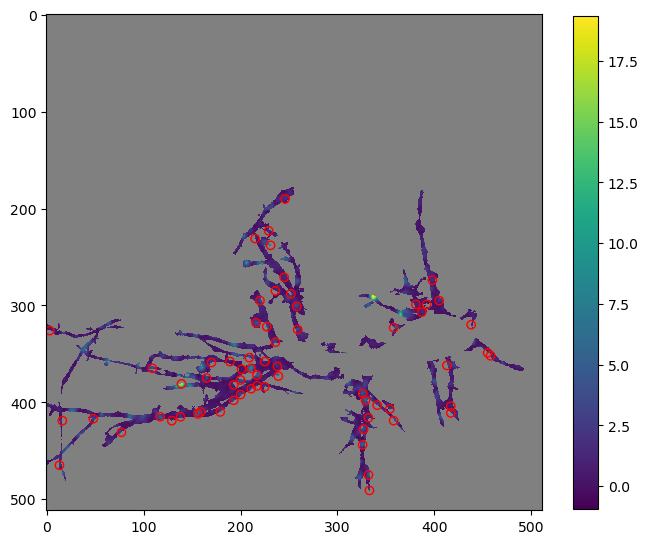

In [282]:
ind = 30   # choose a frame-index
image = cluster[ind]*mask

# Apply maximum filter to detect local maxima
filtered_image = maximum_filter(image, size=10)  # Adjust the size based on expected peak size
peaks = (image == filtered_image)  # Peaks are where the original image equals the maximum filter result

# Label the peaks
labeled_peaks, num_features = label(peaks)
# Mask NaN values to display them with a specific color
# masked_image = np.ma.masked_invalid(|image)

# Create a colormap that shows NaN values as a chosen color
cmap = plt.cm.viridis
cmap.set_bad(color='gray')  # Set the color for NaN values to a chosen color

# Plot the image and overlay the peaks
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(image, cmap=cmap, interpolation='nearest')
cbar = fig.colorbar(im, ax=ax, shrink = 0.8)   # Create a colorbar

# Mark the peaks with red dots
for i in range(1, num_features + 1):
    slice_y, slice_x = find_objects(labeled_peaks == i)[0]
    ax.scatter((slice_x.start + slice_x.stop - 1) / 2, (slice_y.start + slice_y.stop - 1) / 2, facecolor='none', color='r')

plt.show()
# Save as SVG with highest resolution
fig.savefig(data_folder+'\\peak_identification.svg', format='svg', bbox_inches='tight')

### Check threshold for a peak (we are using 1.0 by default)

In [283]:
yo = np.zeros((n_frames,1))
for i in tqdm(range(n_frames)):
    yo[i] = (np.nanpercentile(cluster[i]*mask,50))
print(f'Mean Value: {np.nanmean(yo):.2f}')

100%|██████████| 127/127 [00:00<00:00, 235.38it/s]


Mean Value: 0.84


## Peak Detection over time
### Extract the trajectories

In [284]:
# Parameters for particle detection
diameter = 5  # Approximate size of the particle in pixels
minmass = 1.0  # Minimum integrated brightness (mass) of a particle to be considered (we get an idea from the previous cell)
search_range = 5  # Maximum displacement between frames in pixels

# A list to store particle locations for each frame
particle_positions = []

# Loop through each 2D frame to detect particles
for t in tqdm(range(n_frames)):
    frame = np.nan_to_num(cluster[t] * mask, nan=0)  # Get the 2D frame from the 3D stack (apply mask if needed)
    # Detect particles with sub-pixel accuracy in this frame
    particles = tp.locate(frame, diameter=diameter, minmass=minmass, separation=15)
    
    # Add the frame number to each detected particle's data
    particles['frame'] = t
    
    # Store the detected particles
    particle_positions.append(particles)

# Combine all particle positions across frames into a single DataFrame
peaks_df = pd.concat(particle_positions)

# Use trackpy to link the particles over time
tp_trajectories = tp.link(peaks_df, search_range=search_range)

# Now tp_trajectories contains sub-pixel accurate positions and is linked over time
# print(tp_trajectories.head())


Frame 126: 81 trajectories present.


## Post-processing of the tracks:
### Step-i) Prunning out small tracks: We need a duration of atleast 3 timeframes
### Step-ii) Getting rid of the static and discontinuous tracks

In [285]:
# Filter out tracks with less than 3 frames
tp_trajectories_pruned = tp.filter_stubs(tp_trajectories, 3)  

movement_threshold = 0.0  # Adjust this threshold as needed
tp_trajectories_filtered = filter_tracks(tp_trajectories_pruned, movement_threshold)

# Calculate the duration of each track
track_duration = tp_trajectories_filtered.groupby('particle')['frame'].apply(lambda x: x.max() - x.min() + 1).reset_index(name='track_duration')
short_tracks = track_duration[track_duration['track_duration'] < 3]  # Filter tracks with less than 3 frames
print(short_tracks)   # Display tracks with less than 3 frames


Empty DataFrame
Columns: [particle, track_duration]
Index: []


### Visualizing the filtered tracks 

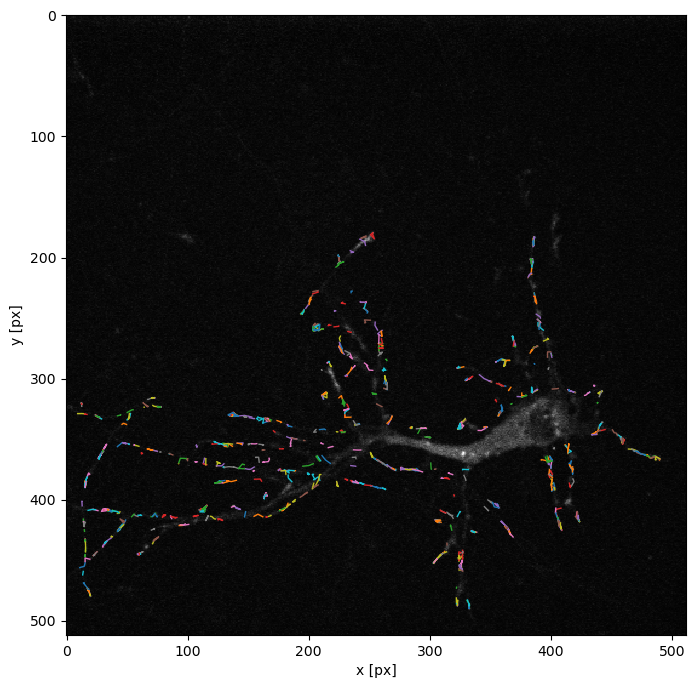

In [286]:
# Visualize the trajectories
fig, ax = plt.subplots(figsize = (8,12))  # Create a figure and axes
tp.plot_traj(tp_trajectories_filtered,superimpose=img[0],ax=ax)  # Pass the axes to the plot_traj function

ax.set_aspect('equal')  # Set equal axis scaling to ensure equal aspect ratio
plt.show()

# Save as SVG with highest resolution
fig.savefig(data_folder+'\\filtered_tracks.svg', format='svg', bbox_inches='tight')

### Visualizing tracks as scatter points

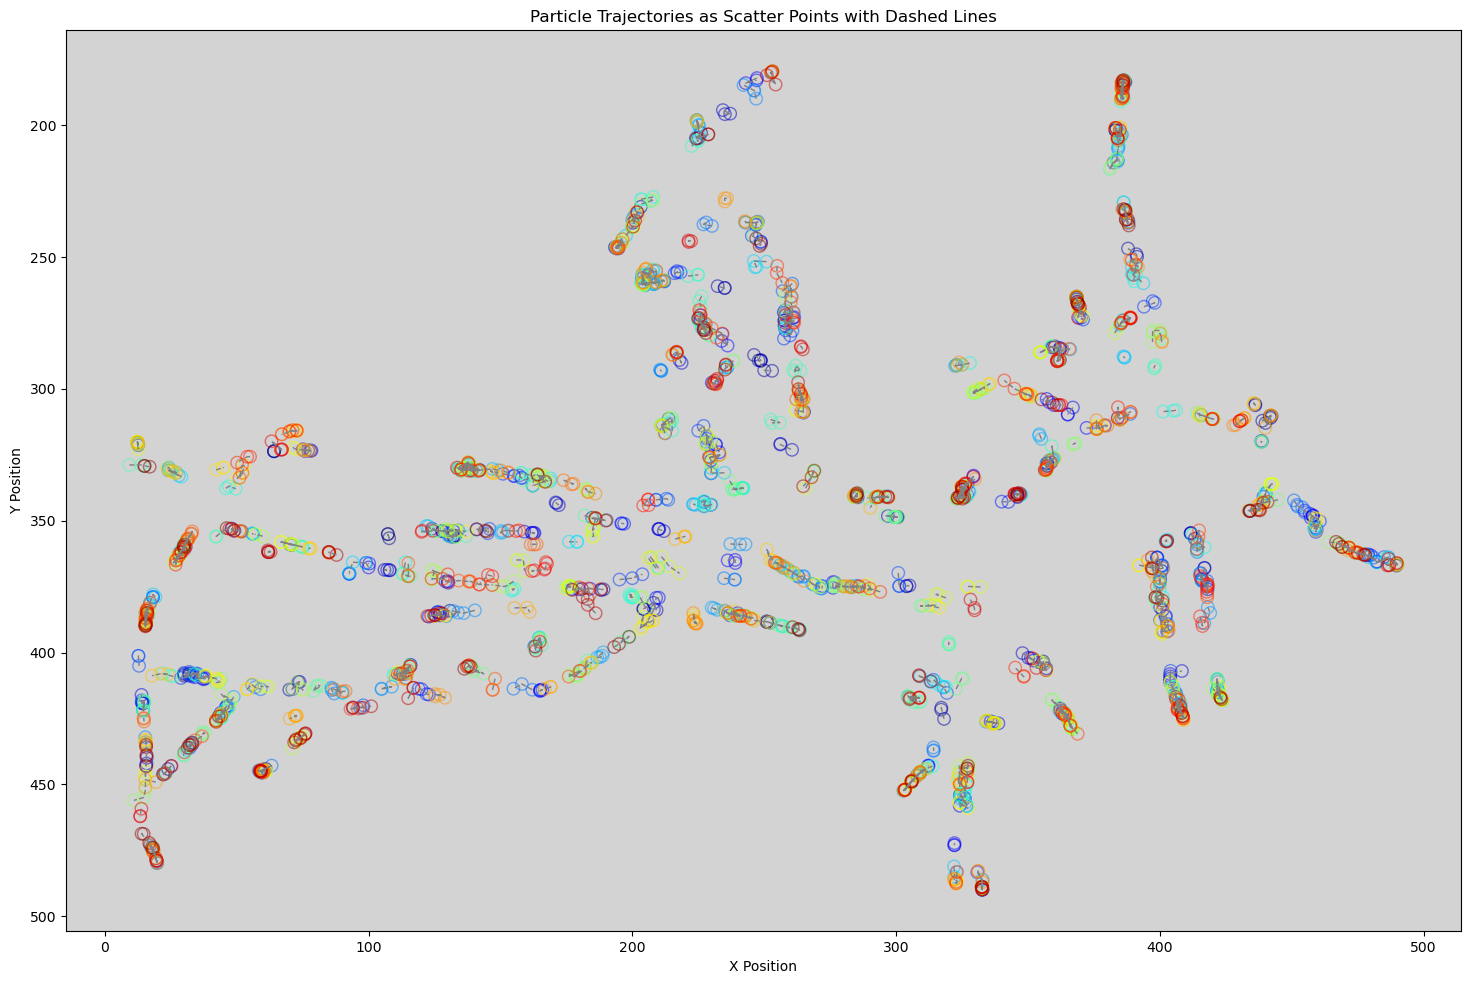

In [287]:
fig, ax = plt.subplots(figsize = (18,12))
colormap = cm.get_cmap('jet')

# Set figure background color to grey
ax.set_facecolor('lightgrey')  # Change to your preferred shade of grey

num_particles = tp_trajectories_filtered['particle'].nunique() # Determine the number of unique particles
colors = colormap(np.linspace(0, 1, num_particles))   # Create a list of colors from the colormap

# Create a color map for the particles
particle_color_map = dict(zip(tp_trajectories_filtered['particle'].unique(), colors))

# Group by particle ID to plot each track separately
for particle_id, track in tp_trajectories_filtered.groupby('particle'):

    # Get color for the current particle
    color = particle_color_map[particle_id]
    
    # Plot scatter points for each frame in the trajectory
    ax.scatter(track['x'], track['y'], s=80, facecolor='none', alpha=0.5, color=color)

    # Connect the points with a dashed line
    ax.plot(track['x'], track['y'], linestyle='--', linewidth=1, color='gray')

# Set axis labels and title
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_title('Particle Trajectories as Scatter Points with Dashed Lines')

# Ensure equal axis scaling
ax.set_aspect('equal')
ax.invert_yaxis()

# Show the plot
plt.show()

# Save as SVG with highest resolution
fig.savefig(data_folder+'\\scatter_tracks.svg', format='svg', bbox_inches='tight')



## Track properties calculation (velocities, length, duration)

In [288]:
# 1. Calculate Instantaneous Shifts (x, y, and frame)
tp_trajectories_filtered['x_shift'] = tp_trajectories_filtered.groupby('particle')['x'].diff()
tp_trajectories_filtered['y_shift'] = tp_trajectories_filtered.groupby('particle')['y'].diff()
tp_trajectories_filtered['frame_shift'] = tp_trajectories_filtered.groupby('particle')['frame'].diff()

# Fill NaN values to preserve the first entry for each particle's track
tp_trajectories_filtered['x_shift'] = tp_trajectories_filtered['x_shift'].fillna(0)
tp_trajectories_filtered['y_shift'] = tp_trajectories_filtered['y_shift'].fillna(0)
tp_trajectories_filtered['frame_shift'] = tp_trajectories_filtered['frame_shift'].fillna(1)  # Assume frame_shift is 1 for the first frame

# Calculate instantaneous displacement magnitude (distance per frame)
tp_trajectories_filtered['displacement'] = np.sqrt(tp_trajectories_filtered['x_shift']**2 + tp_trajectories_filtered['y_shift']**2)

# Calculate instantaneous velocity magnitude (displacement per frame)
tp_trajectories_filtered['velocity'] = tp_trajectories_filtered['displacement'] / tp_trajectories_filtered['frame_shift']

# Remove NaN values from displacement and velocity
tp_trajectories_filtered = tp_trajectories_filtered.dropna(subset=['displacement', 'velocity'])

# Calculate the Total Track Length (Sum of displacements per particle)
track_lengths = tp_trajectories_filtered.groupby('particle')['displacement'].sum().reset_index(name='track_length')

# Calculate the Track Duration (Count of unique frames per particle)
track_duration = tp_trajectories_filtered.groupby('particle')['frame'].nunique().reset_index(name='track_duration')

# Calculate the start and end locations and total time for each particle
track_properties = tp_trajectories_filtered.groupby('particle').agg(
    x_start=('x', 'first'),
    y_start=('y', 'first'),
    x_end=('x', 'last'),
    y_end=('y', 'last'),
    frame_start=('frame', 'first'),
    frame_end=('frame', 'last')
).reset_index()

# Calculate the distance and total time for each track
track_properties['distance'] = np.sqrt((track_properties['x_end'] - track_properties['x_start'])**2 +
                                       (track_properties['y_end'] - track_properties['y_start'])**2)
track_properties['total_time'] = track_properties['frame_end'] - track_properties['frame_start']

# Calculate the average velocity for each track
track_properties['avg_velocity'] = track_properties['distance'] / track_properties['total_time']

# Merge the results back into a single DataFrame
track_properties = pd.merge(track_properties, track_lengths, on='particle')
track_properties = pd.merge(track_properties, track_duration, on='particle')

# Optionally merge track_properties back with the original dataframe if you want to keep all the data
tp_trajectories_filtered = pd.merge(tp_trajectories_filtered, track_properties, on='particle')

# Now, 'tp_trajectories_filtered' contains instantaneous velocities, total track length, and redefined average velocity.


## Plotting the distributions
### Track duration distribution (#frames)

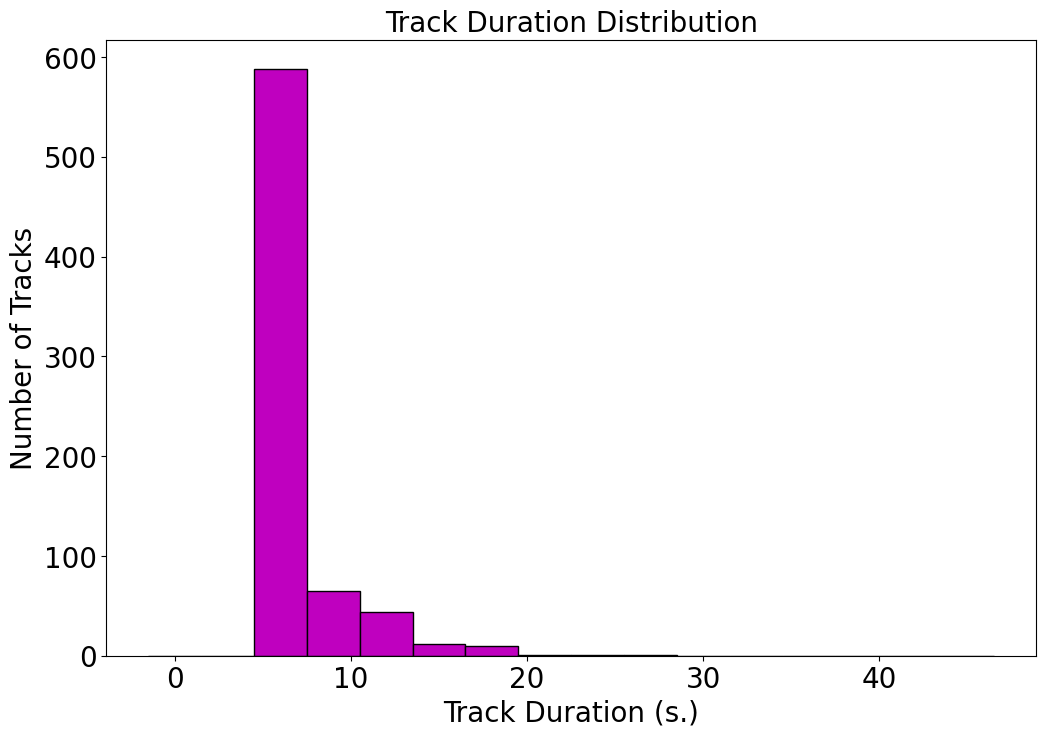

In [289]:
# Plot Track Duration Distribution
fig, ax = plt.subplots(figsize = (12,8))

plt.hist(track_properties['track_duration']*frame_interval, bins=np.arange(0,51,3), color='m', edgecolor='k', align='left')
plt.title('Track Duration Distribution', fontsize=20)
plt.xlabel('Track Duration (s.)', fontsize=20)
plt.ylabel('Number of Tracks', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=8)
plt.grid(False)
plt.show()
# Save as SVG with highest resolution
fig.savefig(data_folder+'\\track_durations.svg', format='svg', bbox_inches='tight')


### Track distance distribution (#pixels)

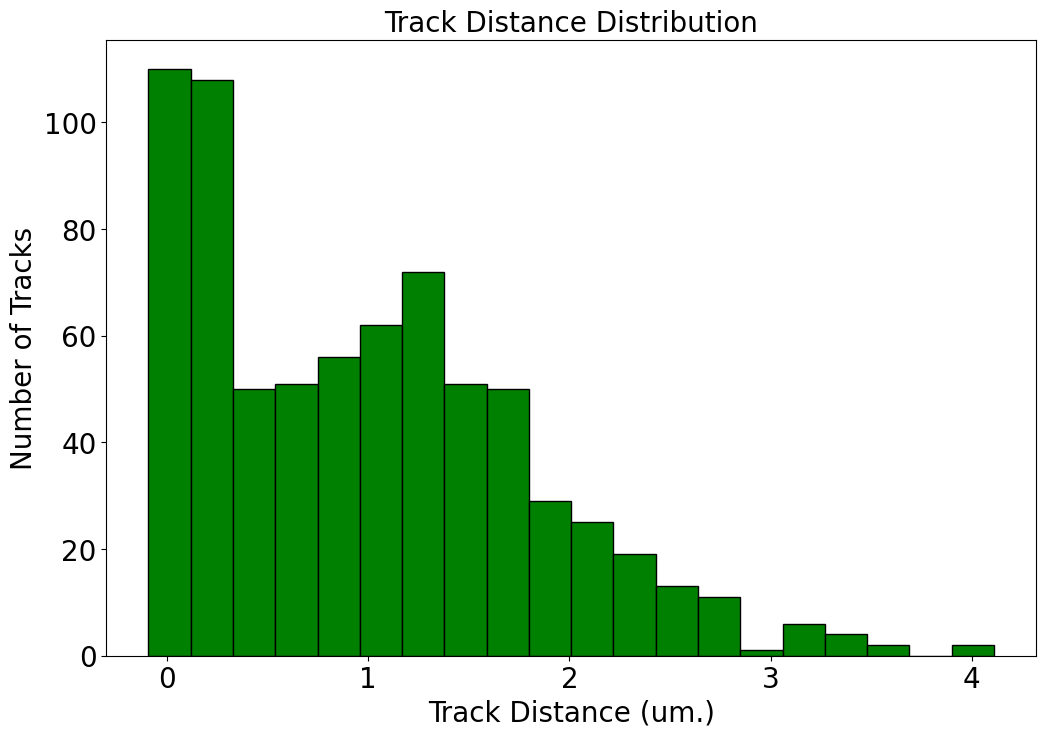

In [290]:
# Plot Track Duration Distribution
fig, ax = plt.subplots(figsize = (12,8))

plt.hist(track_properties['distance']/resolution, bins=20, color='g', edgecolor='k', align='left')
plt.title('Track Distance Distribution', fontsize=20)
plt.xlabel('Track Distance (um.)', fontsize=20)
plt.ylabel('Number of Tracks', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=8)
plt.grid(False)
plt.show()
# Save as SVG with highest resolution
fig.savefig(data_folder+'\\track_distance.svg', format='svg', bbox_inches='tight')

### Track velocities distribution (#px/frame)

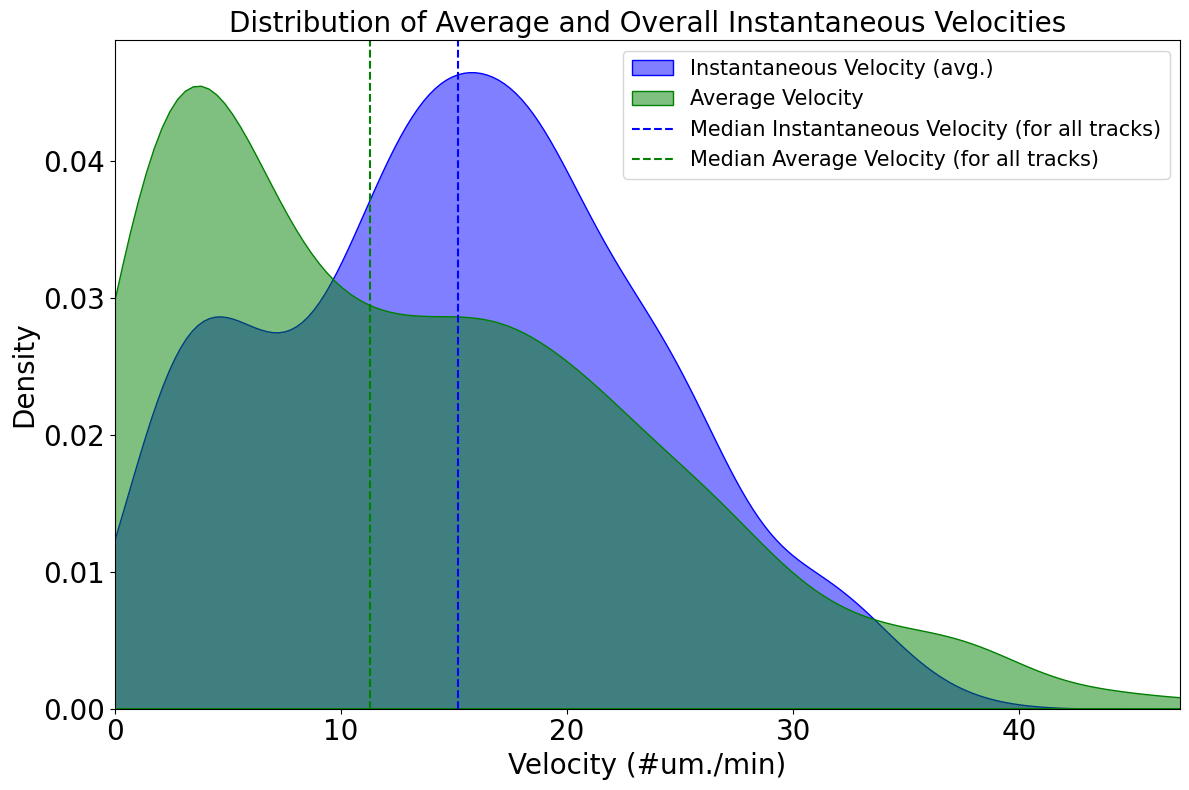

In [291]:
# Calculate average instantaneous velocity for each particle (track)
avg_velocities = tp_trajectories_filtered.groupby('particle')['velocity'].mean().reset_index(name='avg_velocity')

# Set up the figure
fig, ax = plt.subplots(figsize = (12,8))

# Plot average instantaneous velocity distribution
sns.kdeplot(avg_velocities['avg_velocity']*60/(resolution*frame_interval), label='Instantaneous Velocity (avg.)', color='blue', fill=True, alpha=0.5).set(xlim=(0))

# Plot for overall average velocities
sns.kdeplot(track_properties['avg_velocity']*60/(resolution*frame_interval), label='Average Velocity', color='green', fill=True, alpha=0.5).set(xlim=(0))

# Add vertical lines for means
plt.axvline(np.median(avg_velocities['avg_velocity'])*60/(resolution*frame_interval), color='blue', linestyle='--', label='Median Instantaneous Velocity (for all tracks)')
plt.axvline(np.median(track_properties['avg_velocity'])*60/(resolution*frame_interval) , color='green', linestyle='--', label='Median Average Velocity (for all tracks)')

# Set labels and title
plt.xlabel('Velocity (#um./min)', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.title('Distribution of Average and Overall Instantaneous Velocities', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=8)
plt.legend(fontsize=15)
plt.tight_layout()
plt.show()
fig.savefig(data_folder+'\\track_velocities.svg', format='svg', bbox_inches='tight')

In [292]:
print(f'Number of unique tracks: {num_particles:.2f}')
tp_trajectories_filtered

Number of unique tracks: 722.00


,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,...,y_start,x_end,y_end,frame_start,frame_end,distance,total_time,avg_velocity,track_length,track_duration
0,183.912621,385.718447,17.822935,1.246354,0.128510,2.768611,88.591631,0.001812,0,0,...,183.912621,386.210526,184.162679,0,2,0.551971,2,0.275985,2.014168,3
1,367.019048,489.647619,4.542253,1.183216,0.437710,0.821931,23.964348,0.006699,0,11,...,367.019048,489.823077,366.784615,0,2,0.292821,2,0.146410,1.147678,3
2,453.886957,324.313043,9.949697,1.264911,0.113168,1.557344,57.893345,0.002772,0,24,...,453.886957,325.744361,454.821429,0,2,1.709359,2,0.854679,1.709427,3
3,446.114068,22.095057,11.377262,1.165081,0.387268,1.816901,65.113109,0.002465,0,25,...,446.114068,25.188925,442.993485,0,4,4.394321,4,1.098580,4.633897,5
4,355.039497,107.328546,24.095570,1.352569,0.049697,2.898390,170.940438,0.000939,0,41,...,355.039497,107.218077,355.170732,0,2,0.171539,2,0.085770,3.298905,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2739,353.247078,140.934891,29.878849,1.253376,0.246126,4.539191,183.046794,0.001131,126,6621,...,353.799043,140.934891,353.247078,124,126,3.241633,2,1.620817,4.721426,3
2740,268.031325,369.074699,20.700705,1.270613,0.305958,3.641329,99.734777,0.002076,126,6615,...,265.373288,369.074699,268.031325,124,126,2.738622,2,1.369311,2.770103,3
2741,245.825427,248.235294,26.287401,1.176945,0.214087,4.389547,128.821611,0.001607,126,6617,...,242.982456,248.235294,245.825427,124,126,3.132572,2,1.566286,3.763806,3
2742,238.085627,388.192661,16.311158,1.314469,0.209220,2.244655,95.715975,0.002163,126,6465,...,231.916667,388.192661,238.085627,121,126,6.487579,5,1.297516,7.836200,6


In [293]:
# Save DataFrame to CSV
save_path = data_folder+'\\'
tp_trajectories_filtered.to_csv(save_path+'tp_trajectories_filtered.csv', index=False)
track_properties.to_csv(save_path+'track_properties.csv', index=False)


### What's the 1px/frame speed equivalent in #um./min

In [294]:
60/(resolution*frame_interval)

10.799913600691195